# Tasks (homework)
Your tasks are the following:
1. Add some other type of image augmentation to the training pipeline. Check out the list of available transforms here: https://pytorch.org/vision/main/transforms.html. Visualize the training images, save the generated figure.
2. Add batch normalization layers (2D) to our custom CNN, after each ReLU. Keep the network width at 64. What is the exact number of parameters in the original network? print it out! What is the exact number of trainable parameters in the new network? print it out!
3. Add a confusion matrix to your metrics (https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html). Run an evaluation, and visualize the confusion matrix.


In [1]:
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
import wandb
import datasets
import random
import torchmetrics
from torchmetrics import ConfusionMatrix
import seaborn as sns
import numpy as np


In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
resolution = 112
num_classes = 3

batch_size = 32
num_workers = 2
num_epochs = 30
learning_rate = 3e-4
weight_decay = 1e-4
width = 64

In [5]:
class DogFoodDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        angle = random.choice([0, 15, 30, 45, 60, 75, 90])
        self.train_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.RandomRotation(degrees=angle),
            # transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def preprocess_train(self, batch):
        batch["image"] = [self.train_transform(image) for image in batch["image"]]
        return batch

    def preprocess_val(self, batch):
        batch["image"] = [self.val_transform(image) for image in batch["image"]]
        return batch

    def setup(self, stage=None):
        self.train_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="train"
        ).with_transform(self.preprocess_train)
        self.val_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()

In [6]:
datamodule = DogFoodDataModule()
datamodule.prepare_data()
datamodule.setup()

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/750 [00:00<?, ? examples/s]

In [7]:
def visualize_images(dataset, num_images, num_augmentations):
    class_names = ["chicken", "dog", "muffin"]
    plt.figure(figsize=(num_augmentations * 2, num_images * 2))
    for row in range(num_images):
        for column in range(num_augmentations):
            image = dataset[row]["image"]
            label = dataset[row]["label"]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy())
            if column == 0:
                plt.title(class_names[label], loc="left")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

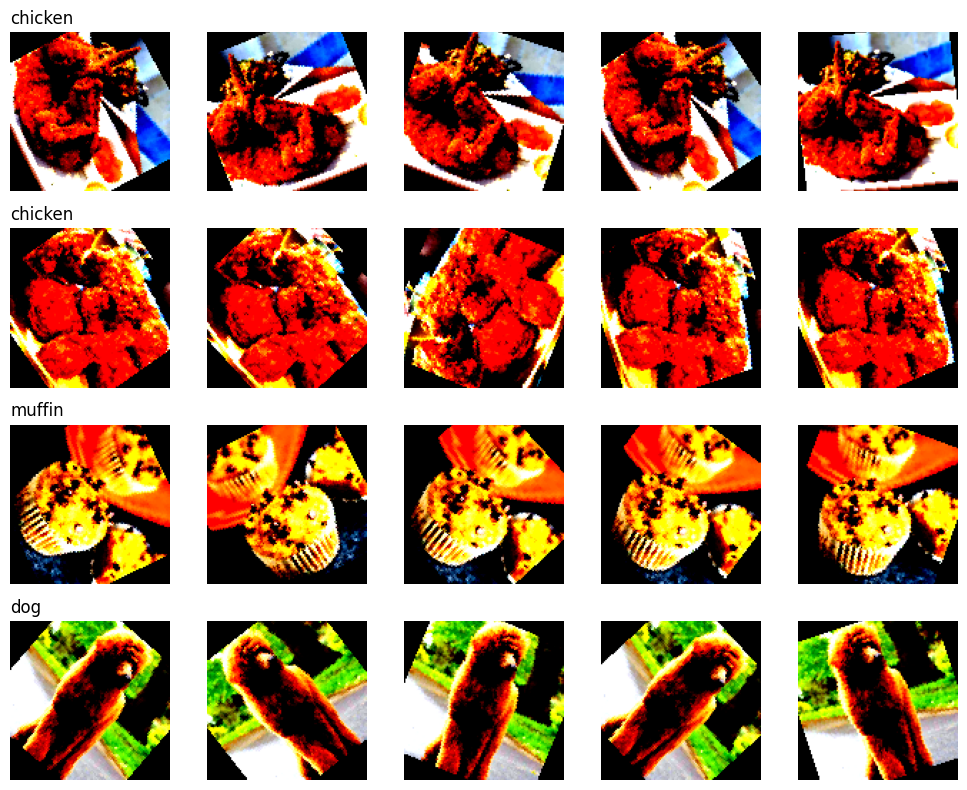

In [8]:
visualize_images(datamodule.train_dataset, num_images=4, num_augmentations=5)

In [9]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super(ImageClassifier, self).__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        y_pred = torch.argmax(pred_labels, dim=1)
        self.confusion_matrix.update(y_pred, batch["label"])
        if batch_idx == len(self.trainer.datamodule.test_dataloader()) - 1:
          conf_matrix = self.confusion_matrix.compute().cpu().numpy()
          # 计算每个格子中的正确分类概率
          class_counts = np.sum(conf_matrix, axis=1)  # 每个类别的总样本数
          normalized_conf_matrix = conf_matrix / class_counts[:, np.newaxis]  # 将混淆矩阵中的元素除以对应类别的总样本数

          # 打印和可视化每个格子的正确分类概率
          print("Confusion Matrix with Class-wise Accuracy:")
          print(normalized_conf_matrix)

          plt.figure(figsize=(num_classes, num_classes))
          class_labels = [str(i) for i in range(num_classes)]
          sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
          plt.xlabel('Predicted Labels')
          plt.ylabel('True Labels')
          plt.title('Confusion Matrix with Class-wise Accuracy')
          plt.show()


        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)


In [10]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

# print(model)
# print(model(torch.randn(batch_size, 3, resolution, resolution)).shape)
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the original network : {total_params}')

Total number of parameters in the original network : 112771


In [11]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(num_features=width, affine=True),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(num_features=width, affine=True),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(num_features=width, affine=True),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(num_features=width, affine=True),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

# print(model)
# print(model(torch.randn(batch_size, 3, resolution, resolution)).shape)
# total_params = sum(p.numel() for p in model.parameters())
# print(f'Total number of parameters in the original network : {total_params}')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of trainable parameters in the new network: {total_trainable_params}')

Total number of trainable parameters in the new network: 113283


In [12]:
lit_model = ImageClassifier(model)

In [20]:
wandb_logger = pl.loggers.WandbLogger(project="solution-11.07practice", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed",
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model, datamodule)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                      | Params
---------------------------------------------------------------
0 | model            | Sequential                | 113 K 
1 | accuracy         | MulticlassAccuracy        | 0     
2 | confusion_matrix | MulticlassConfusionMatrix | 0     
---------------------------------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.453     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_acc_epoch,▂▁▄▄▄▅▄▄▄▄▅▄▅▆▅▆▆▃▆▅▅▆▆█▆▆▆▇▇█
train_acc_step,▃▅▆▆█▅▃▅▃█▅▅▅▅██▆▃█▆▅▃██▃██▁▃▅██▆█▆▅██▆▅
train_loss_epoch,▇█▆▆▅▅▅▄▅▄▃▆▄▃▃▃▃▅▂▃▃▃▂▁▃▃▃▁▁▁
train_loss_step,▄▇▁▃▁▃▅▇▅▂▄▂▂▃▂▁▂▃▂▂▄▃▁▁▄▁▁▅▃▃▂▂▃▂▃▄▂▂▃█
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▅▁▃▃▅▄▅▅▄▆▅▅▆▂▆▆▅▇▃▆▅▄█▇▆▆▆▇▁▆
val_loss,▄▆▄▄▂▄▂▂▃▂▃▄▃█▂▂▃▂▅▂▂▄▁▁▂▃▂▂█▂
epoch,29
train_acc_epoch,0.9692
train_acc_step,0.9375


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Confusion Matrix with Class-wise Accuracy:
[[0.95633188 0.01746725 0.02620087]
 [0.01176471 0.96862745 0.01960784]
 [0.0112782  0.01879699 0.96992481]]


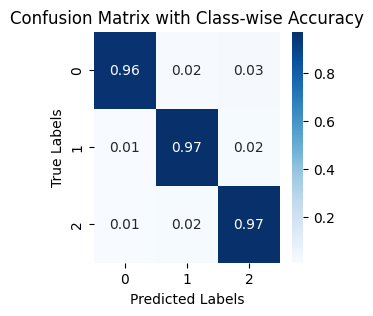

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9653333425521851     │
│         test_loss         │    0.13658329844474792    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.13658329844474792, 'test_acc': 0.9653333425521851}]

In [21]:
best_model_path = checkpoint_callback.best_model_path
best_model = ImageClassifier.load_from_checkpoint(best_model_path, model=model)
best_model.eval()

trainer = pl.Trainer(
    precision="16-mixed",
    accelerator="gpu",
    devices=1,
)

trainer.test(best_model, datamodule)